# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 4: Audiovisual fusion - baseline

- Testing on audio visual fusion with VGG-ish CNN model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from audiovisual_models import *
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

from torchviz import make_dot

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

# Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
Multimodal_dataset_PATH = os.path.join("/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset")
Image_path = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'images')
Audio_raw_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'raw_audio')
Audio_equalized_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'equalized_audio')
Audio_bandpassed_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'bandpassed_audio')
Audio_denoised_seg_PATH = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'denoised_audio')

AUDIO_DIR = Audio_raw_seg_PATH
VISON_DIR = Image_path

torch.manual_seed(0)

ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', "visual_acoustic_dataset_annotations_v2.csv")


classes = ('Laser-off', 'Defect-free', 'Defective')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 10

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils functions

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
# mp.set_start_method("spawn")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [4]:
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
annotations_df.head()

,sample index,audio_file_name,image_file_name,class_name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number
0,0,sample_24_1.wav,sample_24_1.jpg,Crack,2,Defective,2,1,24
1,1,sample_24_2.wav,sample_24_2.jpg,Defect-free,1,Defect-free,1,1,24
2,2,sample_24_3.wav,sample_24_3.jpg,Defect-free,1,Defect-free,1,1,24
3,3,sample_24_4.wav,sample_24_4.jpg,Defect-free,1,Defect-free,1,1,24
4,4,sample_24_5.wav,sample_24_5.jpg,Defect-free,1,Defect-free,1,1,24


In [5]:
# Get the labels and count the number of samples for each class
labels = annotations_df['class_ID'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[2700 1944  163  652]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **53%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [6]:
### Get the percentage distribution of each category
round(annotations_df.groupby('class_ID_2')["class_ID_2"].count()/annotations_df.shape[0]*100, 1)

class_ID_2
0    49.5
1    35.6
2    14.9
Name: class_ID_2, dtype: float64

Saving figure dataset


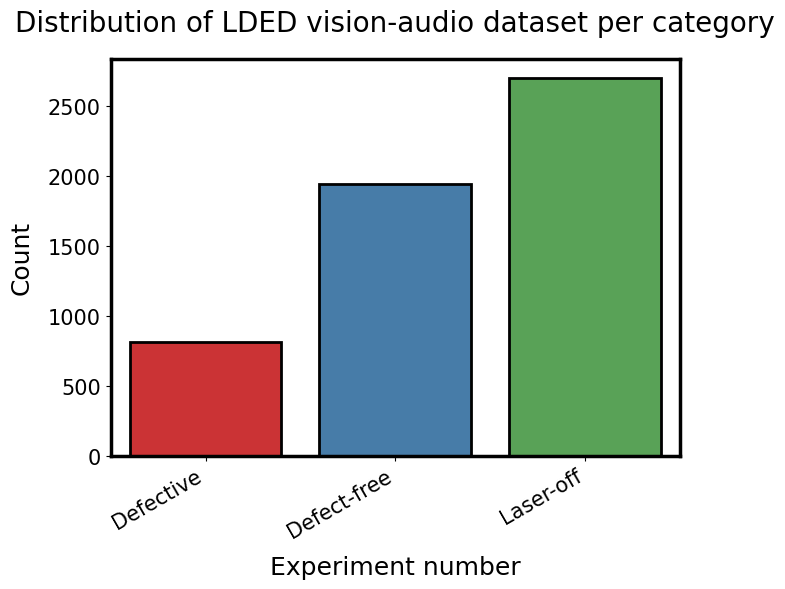

In [7]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='class_name_v2', data = annotations_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [8]:
#------ transformation------
visual_train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_test_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

#------ audio transfomation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
#------ data loader------
# create the dataset for all samples
mmd = MultimodalDataset(annotations_df,
                        VISON_DIR,
                        AUDIO_DIR,
                        visual_train_transforms,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        device)
print ("length of the total dataset:" + str(len(mmd)))

length of the total dataset:5459


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [10]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(annotations_df, labels))

# split the data into train and test sets
train_annotations = annotations_df.iloc[train_indices, :]
test_annotations = annotations_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = MultimodalDataset(train_annotations,
                                  VISON_DIR,
                                  AUDIO_DIR,
                                  visual_train_transforms,
                                  mel_spectrogram,
                                  SAMPLE_RATE,
                                  device)

        
val_dataset = MultimodalDataset(test_annotations,
                                VISON_DIR,
                                AUDIO_DIR,
                                visual_val_transforms,
                                mel_spectrogram,
                                SAMPLE_RATE,
                                device)

In [11]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# # split the indices of annotations into train, validation and test sets
# train_indices, test_val_indices = next(sss.split(annotations_df, labels))

# # Use another StratifiedShuffleSplit to split the test_val_indices into test and validation sets
# val_size = 0.5 # set the validation size
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
# val_indices, test_indices = next(sss2.split(annotations_df.iloc[test_val_indices], labels[test_val_indices]))

# # split the data into train, validation, and test sets
# train_annotations = annotations_df.iloc[train_indices, :]
# val_annotations = annotations_df.iloc[val_indices, :]
# test_annotations = annotations_df.iloc[test_indices, :]

# # Create the train, validation and test datasets
# train_dataset = MultimodalDataset(train_annotations,
#                                   image_path = VISON_DIR,
#                                   audio_path = AUDIO_DIR,
#                                   image_transformation=visual_train_transforms,
#                                   MFCCs = MFCCs,
#                                   target_sample_rate = SAMPLE_RATE,
#                                   device=device)

# val_dataset = MultimodalDataset(val_annotations,
#                                 image_path = VISON_DIR,
#                                 audio_path = AUDIO_DIR,
#                                 image_transformation=visual_val_transforms,
#                                 MFCCs = MFCCs,
#                                 target_sample_rate = SAMPLE_RATE,
#                                 device=device)

# test_dataset = MultimodalDataset(test_annotations,
#                                  image_path = VISON_DIR,
#                                  audio_path = AUDIO_DIR,
#                                  image_transformation=visual_train_transforms,
#                                  MFCCs = MFCCs,
#                                  target_sample_rate = SAMPLE_RATE,
#                                  device=device)

### Create DataLoader using the dataset

In [12]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:4367
length of the val dataset:1092


In [13]:
# model = AudioVisualFusionCNN().to(device)
# loss_fn = nn.CrossEntropyLoss()
# # Note: weight_decay in pytorch is L2 regularization
# # optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
# #                     momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# for batch_idx, (inputs, targets) in enumerate(train_dataloader):
#     inputs = [x.to(device) for x in inputs]
#     targets = targets.to(device)
#     ## forward pass and calculate loss
#     outputs = model(*inputs)
#     # print (outputs)
#     print (targets)
#     # print(inputs[0].size(0))
#     # loss = loss_fn(outputs, targets)

## Training the model

In [14]:
resume = False
start_epoch = 0
best_acc = 0

In [15]:
# -----Model---------------
print('==> Building model..')

net = AudioVisualFusionCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-3) ## consider AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer,
                                                                                               train_dataloader, val_dataloader, EPOCHS, 
                                                                                               scheduler, device, mode = "multi_model")

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.714, accuracy=84.8]


09:39:38 --- Epoch: 0	Train loss: 0.7422	Valid loss: 0.0229	Train accuracy: 82.85	Valid accuracy: 84.80

Epoch: 1


Epoch 1:   0%|                | 0/35 [00:10<?, ?it/s, loss=0.699, accuracy=86.4]


09:40:19 --- Epoch: 1	Train loss: 0.7036	Valid loss: 0.0224	Train accuracy: 85.21	Valid accuracy: 86.45

Epoch: 2


Epoch 2:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.699, accuracy=86.4]


09:41:00 --- Epoch: 2	Train loss: 0.6882	Valid loss: 0.0224	Train accuracy: 86.76	Valid accuracy: 86.36

Epoch: 3


Epoch 3:   0%|                  | 0/35 [00:11<?, ?it/s, loss=0.616, accuracy=94]


09:41:42 --- Epoch: 3	Train loss: 0.6505	Valid loss: 0.0198	Train accuracy: 90.98	Valid accuracy: 93.96

Epoch: 4


Epoch 4:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.595, accuracy=97.3]


09:42:25 --- Epoch: 4	Train loss: 0.6087	Valid loss: 0.0191	Train accuracy: 95.03	Valid accuracy: 97.25

Epoch: 5


Epoch 5:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.605, accuracy=94.6]


09:43:08 --- Epoch: 5	Train loss: 0.6037	Valid loss: 0.0194	Train accuracy: 95.24	Valid accuracy: 94.60

Epoch: 6


Epoch 6:   0%|                | 0/35 [00:10<?, ?it/s, loss=0.581, accuracy=97.5]


09:43:50 --- Epoch: 6	Train loss: 0.5955	Valid loss: 0.0186	Train accuracy: 95.81	Valid accuracy: 97.53

Epoch: 7


Epoch 7:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.574, accuracy=98.6]


09:44:33 --- Epoch: 7	Train loss: 0.5926	Valid loss: 0.0184	Train accuracy: 96.29	Valid accuracy: 98.63

Epoch: 8


Epoch 8:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.591, accuracy=96.2]


09:45:16 --- Epoch: 8	Train loss: 0.5943	Valid loss: 0.0190	Train accuracy: 96.11	Valid accuracy: 96.15

Epoch: 9


Epoch 9:   0%|                | 0/35 [00:11<?, ?it/s, loss=0.573, accuracy=98.5]

09:45:57 --- Epoch: 9	Train loss: 0.5904	Valid loss: 0.0184	Train accuracy: 96.43	Valid accuracy: 98.53


In [16]:
valid_accuracy

[84.7985347985348,
 86.44688644688645,
 86.35531135531136,
 93.95604395604396,
 97.25274725274726,
 94.59706959706959,
 97.52747252747253,
 98.62637362637362,
 96.15384615384616,
 98.53479853479854]

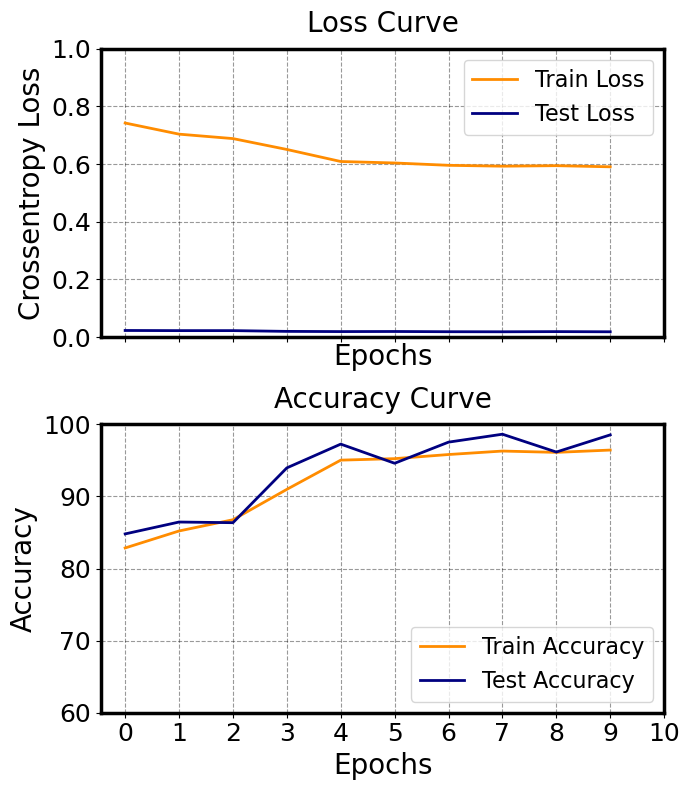

In [17]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.0, yacc_limit1=60, yacc_limit2=100)

In [18]:
get_accuracy(model, val_dataloader, device, mode = 'multi_model')

0.9853479853479854

Test Accuracy (cross-validation) for MFCC-CNN = 0.98535 ± 0.00533
micro-averaging AUC for MFCC-CNN = 0.99808 ± 0.00000
Saving figure ROC_curve (multimodal_fusion-based)


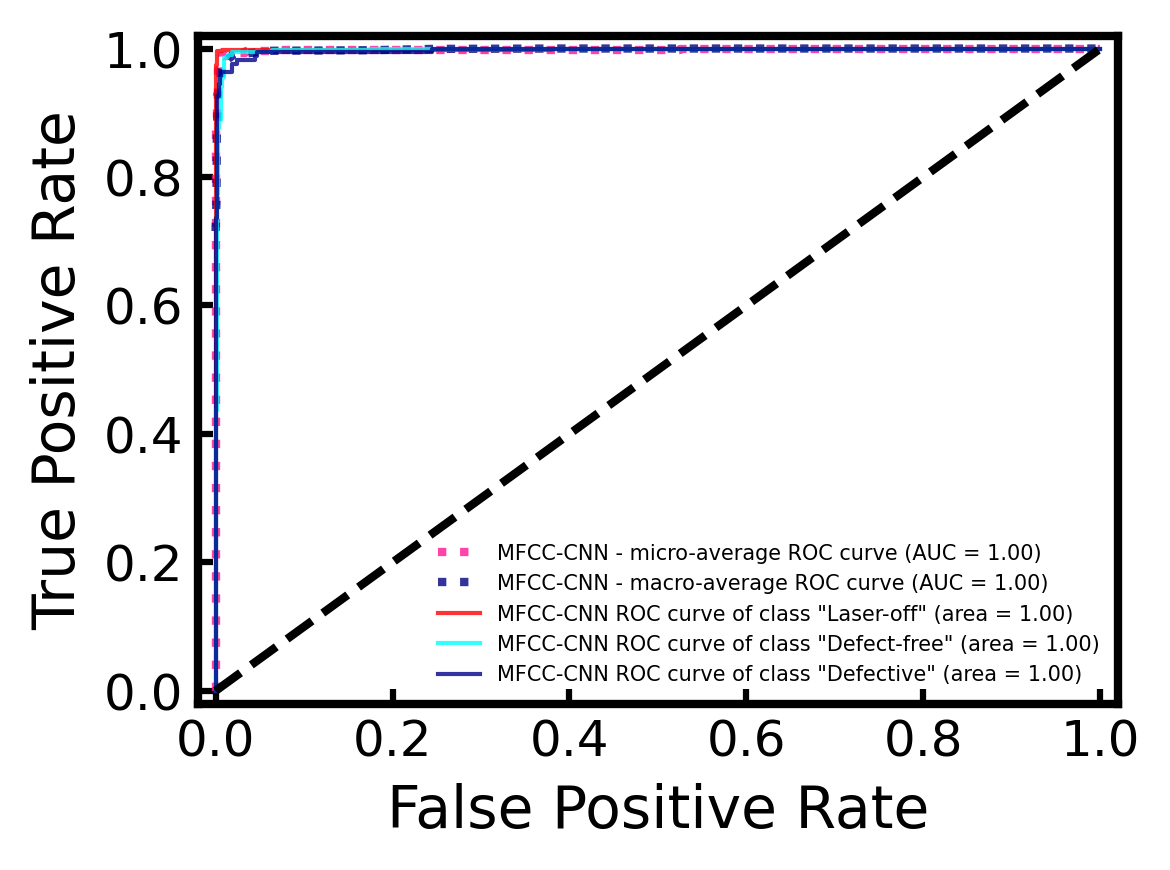

In [19]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN",
                                                                            signal_type = "raw", seed=0, mode = 'multi_model')

save_fig ("ROC_curve (multimodal_fusion-based)")

In [20]:
yt, yp = class_report(model, val_dataloader, device, classes, mode="multi_model")

              precision    recall  f1-score   support

 Defect-free     0.9746    0.9871    0.9808       389
   Defective     0.9686    0.9448    0.9565       163
   Laser-off     0.9981    0.9963    0.9972       540

    accuracy                         0.9853      1092
   macro avg     0.9804    0.9761    0.9782      1092
weighted avg     0.9853    0.9853    0.9853      1092



[[384   4   1]
 [  9 154   0]
 [  1   1 538]]
Saving figure confusion_matrix(audio_visual)


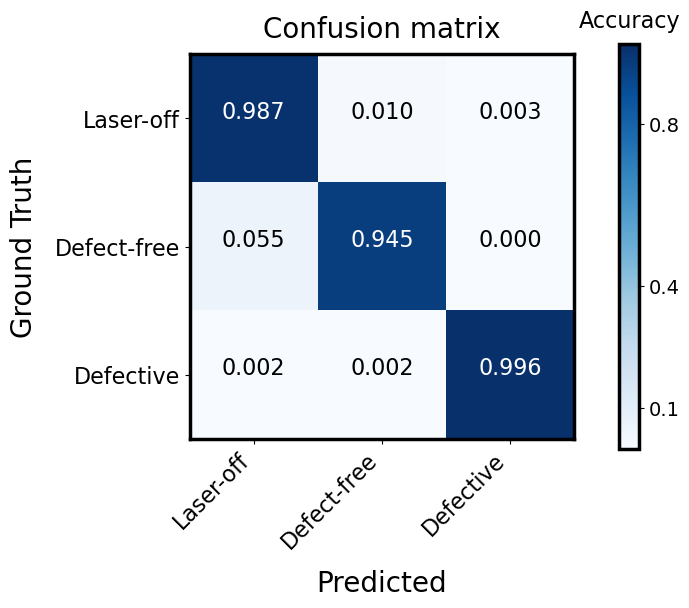

In [21]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_visual)")

In [22]:
# model = AudioVisualFusionCNN()
# image = torch.randn(1, 1, 32, 32)
# audio = torch.randn(1, 1, 20, 8)
# predictions = model(image, audio)
# # make_dot(predictions.mean(), params=dict(model.named_parameters()))
# make_dot(predictions)
# # make_dot(predictions.mean(), params=dict(model.named_parameters()),show_attrs=True, show_saved=True)

In [23]:
# input_names = ['Sentence']
# output_names = ['yhat']
# torch.onnx.export(model, batch.text, 'rnn.onnx', input_names=input_names, output_names=output_names)